# Watershed Project - Mapping Floodplain Connectivity in Boulder County
![Watershed Project](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/South_Boulder_Creek_%28Colorado%29.JPG/1920px-South_Boulder_Creek_%28Colorado%29.JPG)

Image source: [Wikipedia](https://en.wikipedia.org)

## Collaborators and Acknowledgements
Julia Sobczak, Lindsay Chipman, Matthew Bitters, and the [Watershed Center](https://watershed.center/)

## Project Description
### Background and Project Goals
A connected, functional floodplain retains water during periods of high flow and releases it back into the stream when flows are low. Reduced connectivity results in greater magnitude of flood events and vulnerability of surrounding ecosystems to drought. Therefore, understanding connectivity can help guide water resource  management and preparing for potential natural disasters. Through this project, we aim to map floodplain connectivity at 5 target sites in the St. Vrain Basin in Boulder, CO and use the results to evaluate if desired watershed conditions are being met. We will also compare the results between UAV or LiDAR derived data, to see which performs better in terms of quantifying floodplain connectivity.

### Overall Methods
We will use two types of data in our analysis:
1) UAV imagery (to process in Agisoft and create DTM), source: DJI Phantom 4, collected by contractor in Spring & Fall 2022
2) LiDAR data (downloaded as DTM), source: [Colorado Hazard Mapping, Airborne Snow Observatories](https://coloradohazardmapping.com/lidarDownload)

For each of these datasets, we will create digital elevation models (DEM), and digital terrain models (DTM; DEM with vegetation removed) for each site using Agisoft software. (for the lidar data, we may also use download an already created DEM/DTM available from the [Colorado Hazard site](https://coloradohazardmapping.com/lidarDownload). We will then create relative elevation models for the five DTMs with two different methods. THe first method follows the watershed center's protocol, which relies on using the Colorado Water Conservation Board’s REM Generator Tool in ArcMap to create the REM. We would use this for both UAV- and LiDAR-derived DTMs and compare the results. The second method is to use python tools (notably the RiverREM package) to create the REM.

Our end products include an REM and histogram for each of the 5 sites, created from both UAV- and LiDAR-derived data as well as a qualitative and quantitative comparison between the two data sources to suggest which method is best for The Watershed Center to replicate Ultimately, we hope to replicate the watershed's existing process using python tools to  come up with an open and reproducible analysis for generating the REMs. Potential tools are: rasterio/rioxarray (to open and view DTMs), RiverREM (to create REM), and potentially others for plotting and reproducing data downloads and setting file paths/directories. We would use this for both UAV- and LiDAR-derived DTMs and compare.

### This Notebook
In this notebook, we plot the study sites and generate a prelimarary REM using a pre-processed DTM from the highway 93 site. The DTM was created by processing UAV-derived images in agisoft (this step was completed by the Watershed Center). We loaded this DTM to a GitHub release to allow the user of this notebook to download it. We also provide a  shapefile of the centerline of the River at the study site, which was genereated in ArcGIS. 

In [1]:
# set local paths
#dtm = r'C:\Users\Julia\Documents\CU_Earth Data Analytics\Spring Project\DEM_DTM_ortho\DTM_Highway93.tif'
#centerline_shp = r'C:\Users\Julia\Documents\CU_Earth Data Analytics\Spring Project\RiverREM\streamline_js_highway93.shp'
#out_dir = r'C:\Users\Julia\Documents\CU_Earth Data Analytics\Spring Project\RiverREM\test2'

In [2]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib
import zipfile

import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt 
import requests
from riverrem.REMMaker import REMMaker, clear_osm_cache
import rasterio as rio
import xarray as xr
import rioxarray as rxr

In [3]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')
if not os.path.exists(working_dir):
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    
os.chdir(working_dir)

# Study Sites
The study sites are five streams in the St. Vrain Watershed, wihtin Boulder County. For this notebook, only data from the Highway 93 site was used.

In [4]:
# Lindsay to insert script to plot study site figure

In [5]:
# Download streamline shapefile from project repository
# Note - this isn't working yet, delete cell and run rem without shp file if not fixed by tomorrow
override_cache = True
centerline_shp_url = ("https://github.com/lechipman/watershed-project"
                      "/blob/main/streamline_js_highway93.zip")
dtm_dir = os.path.join('uav_hwy93')
centerline_shp_path = os.path.join(dtm_dir, 'streamline_js_highway93.zip')
# Create directory and download centerline file if doesn't exist
if not os.path.exists(dtm_dir):
    print('{} does not exist. Creating...'.format(dtm_dir))
    os.makedirs(dtm_dir)
    
if (not os.path.exists(centerline_shp_path)) or override_cache:
    print('{} does not exist. Downloading...'.format(centerline_shp_path))
    # Open centerline file 
    response = requests.get(centerline_shp_url)
    
    # Open a local file with wb permission and write response content
    with open(centerline_shp_path, 'wb') as centerline_file:
        centerline_file.write(response.content)
        
    # Decompress zip file
#    with zipfile.ZipFile(centerline_shp_path, 'r') as centerline_zipfile:
 #       centerline_zipfile.extractall(dtm_dir)

uav_hwy93/streamline_js_highway93.zip does not exist. Downloading...


In [6]:
# Define url, directory, and path to DTM
hwy_93_url = ("https://github.com/lechipman/watershed-project/releases"
              "/download/v1.0.0/DTM_Highway93.tif")
dtm_dir = os.path.join('uav_hwy93')
dtm_path = os.path.join(dtm_dir, 'DTM_Highway93.tif')   

In [7]:
# Create directory and download DTM file if doesn't exist
override_cache = False
if not os.path.exists(dtm_dir):
    print('{} does not exist. Creating...'.format(dtm_dir))
    os.makedirs(dtm_dir)
    
if (not os.path.exists(dtm_path)) or override_cache:
    print('{} does not exist. Downloading...'.format(dtm_path))
    # Opem DTM file 
    response = requests.get(hwy_93_url)
    
    # Open a local file with wb permission and write response content
    with open(dtm_path, 'wb') as dtm_file:
        dtm_file.write(response.content)

# This is what the DTM  looks like (derived from UAV imagery in Agisoft)

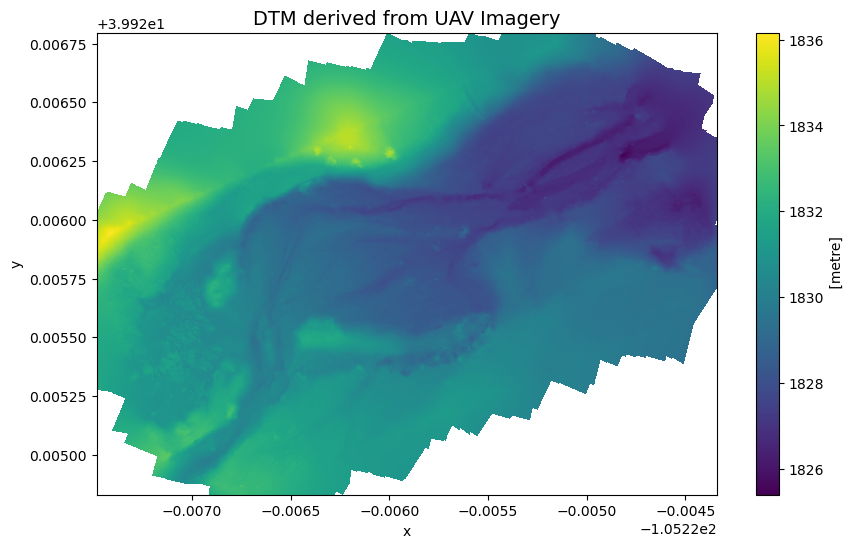

In [8]:
# Open and plot the DTM
dtm = rxr.open_rasterio(dtm_path, masked=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

dtm.plot(ax=ax)
ax.set_title('DTM derived from UAV Imagery', fontsize=14);

# We now use the RiverREM tool to create an REM, using the DTM as input
RiverREM is a Python package for automatically generating river relative elevation model (REM) visualizations from an input DEM. For this notebook, we are have the tool define the centerline of the stream, but in future iterations, we will create our own centerline shapefile to input as a parameter in the rem_maker. This will allow better comparison with the Watershed Center's current process. 

Larrieu, K. (2022). RiverREM (Version 1.0.4) [Computer software]. https://github.com/OpenTopography/RiverREM

In [9]:
# Run rem_maker without specified centerline
# Input the DEM file path and desired output directory
rem_maker = REMMaker(dem=dtm_path, out_dir=dtm_dir, interp_pts=1000) #, centerline_shp = centerline_shp_path)
# create an REM
rem_maker.make_rem()
# create an REM visualization with the given colormap
rem_maker.make_rem_viz(cmap='mako_r')

[INFO] 2023-05-01 21:19:37,384 - Getting DEM projection.
[INFO] 2023-05-01 21:19:37,412 - Reading DEM as array.
[INFO] 2023-05-01 21:19:41,329 - Getting DEM bounds.
[INFO] 2023-05-01 21:19:41,348 - Mapping array indices to coordinates.
[INFO] 2023-05-01 21:19:41,402 - Finding river centerline.
[INFO] 2023-05-01 21:19:41,528 - Found river(s): Coal Creek
[INFO] 2023-05-01 21:19:41,528 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-05-01 21:19:42,132 - 	Coal Creek: 0.0035 degree
[INFO] 2023-05-01 21:19:42,133 - 
Longest river in domain: Coal Creek

[INFO] 2023-05-01 21:19:42,150 - Making river points shapefile.
[INFO] 2023-05-01 21:19:42,217 - Getting river elevation at DE


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/DTM_Highway93_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/DTM_Highway93_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/DTM_Highway93_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved uav_hwy93/DTM_Highway93_hillshade-color.tif.

Generating .png file.
Saved uav_hwy93/DTM_Highway93_hillshade-color.png.


'uav_hwy93/DTM_Highway93_hillshade-color.tif'

# This is an REM Image generated with the RiverREM tool in python
We are noticing some streaks in the image, perpendicular to the river channel, which may indicate poor interpolation and needs to investigate further

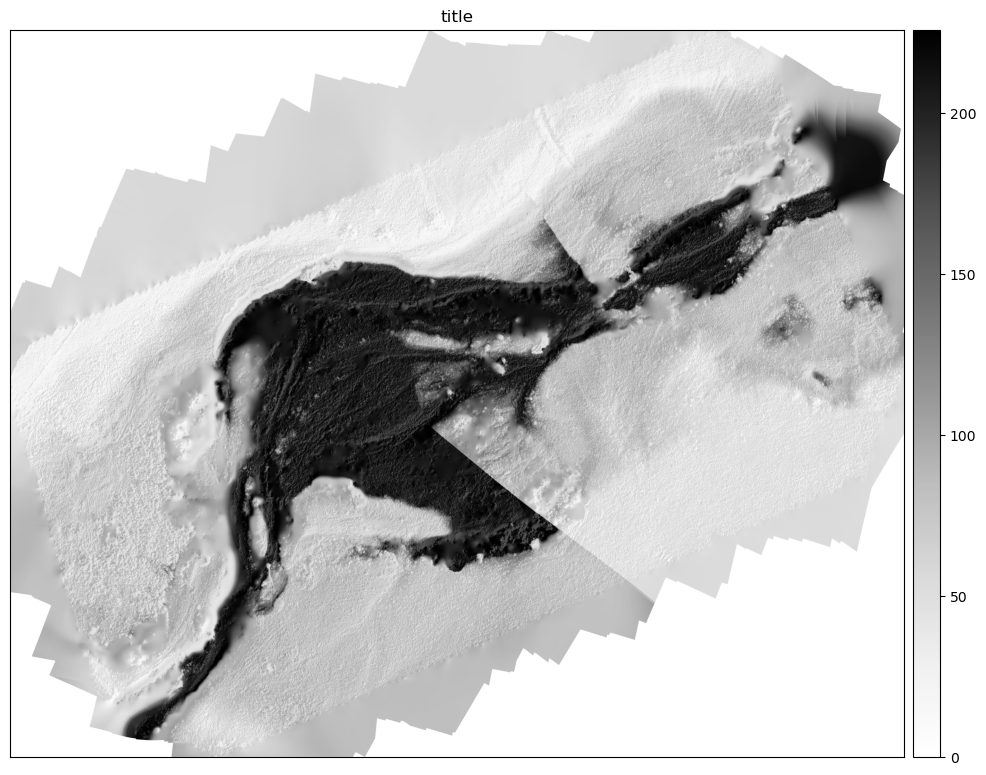

<Axes: title={'center': 'title'}>

In [10]:
# Define REM output path
# Path to the REM you just generated
rem_path = os.path.join(dtm_dir, 'DTM_Highway93_hillshade-color.tif')

# Open rem raster
with rio.open(rem_path) as rem_src:
    rem_pre_arr = rem_src.read(1)
    
# Plot
ep.plot_bands(rem_pre_arr,
               title="Highway 93 REM",
               cmap="Greys")

# Below is a histogram of the REM
The histogram indicates what elevations occur most frequently. A gently sloping curve (away from zero) may indicate better floodplain connectivity 

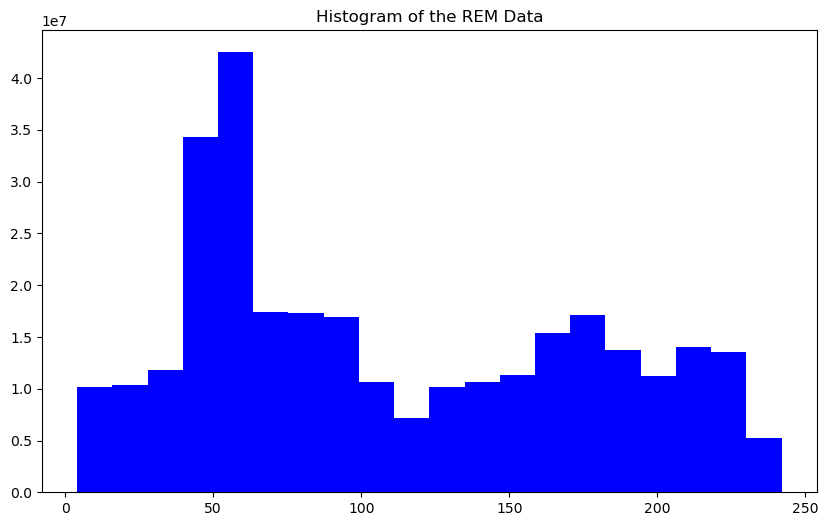

In [12]:
rem = rxr.open_rasterio(rem_path, masked=True).squeeze()

fig, ax = plt.subplots(figsize=(10, 6))
rem.plot.hist(color="cyan",
                      bins=20)
ax.set_title("Histogram of the REM Data")
plt.show()

# Redo open/plot using rem generated from rxr (this isn't workign for me yet)
# Plot the REM
#rem.plot()
#plt.show()